# 03 Cálculo del Índice de Kothari

Objetivo del Notebook: Realizar la regresión de Kothari y calcular el índice de devengos discrecionales (Discretionary Accruals Index), que corresponden a los residuos de la regresión explicada en el notebook 02.

## Carga de datos y configuración inicial

In [30]:
# Cargar la sesión de Kedro
%load_ext kedro.ipython
%reload_kedro

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


[11/02/25 22:10:31] INFO     Resolved project path as:                                              ]8;id=437784;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=617735;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#180\180]8;;\
                             /home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/k                
                             otari-gender-data-analysis.                                                           
                             To set a different path, run '%reload_kedro <project_root>'                           

[11/02/25 22:10:32] INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=709543;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro_telemetry/plugin.py\plugin.py]8;;\:]8;id=471998;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro_telemetry/plugin.py#243\243]8;;\
                             the product. No personal data or IP addresses are stored on our side. To              
                             opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment              
                             variables, or create a `.telemetry` file in the current working                       
                             directory with the contents `consent: false`. To hide this message,                   
                             explicitly grant or deny consent. Read more at                                        
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

                    INFO     Kedro project kotari-gender-data-analysis                              ]8;id=839292;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=37273;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#146\146]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=788815;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=553492;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#147\147]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=156612;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=187426;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#153\153]8;;\

In [31]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
from IPython.display import display, Markdown

# Configurar el estilo de gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [32]:
# Cargar el dataset filtrado generado en el notebook 02
df_kothari = catalog.load("filtered_kothari_data")
print(f"Dataset cargado con {df_kothari.shape[0]} filas y {df_kothari.shape[1]} columnas")
print(f"Empresas únicas: {df_kothari['EMPRESA'].nunique()}")
print(f"Años cubiertos: {sorted(df_kothari['ANIO'].unique())}")

                    INFO     Loading data from filtered_kothari_data (ParquetDataset)...        ]8;id=397877;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=585257;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#403\403]8;;\

Dataset cargado con 158 filas y 28 columnas
Empresas únicas: 16
Años cubiertos: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


## Preparación de variables para la regresión

Conforme a la ecuación de Kothari:

$$
\frac{TA_{i,t}}{A_{i,t-1}} = \alpha_0 + \alpha_1(\frac{1}{A_{i,t-1}}) + \alpha_2(\frac{(\Delta REV_{i,t} - \Delta REC_{i,t})}{A_{i,t-1}}) + \alpha_3(\frac{PPE_{i,t}}{A_{i,t-1}}) + \alpha_4 ROA_{i,t} + \varepsilon_{i,t}
$$

Se crearán las variables necesarias para la regresión.

In [33]:
# Crear una copia del DataFrame para trabajar
df_regresion = df_kothari.copy()

# Variable dependiente: TA / A_{i,t-1}
col_activos = 'Activos total al inicio de anio'
col_ta = 'TA'
df_regresion['Y'] = df_regresion[col_ta] / df_regresion[col_activos]

# Variables independientes según Kothari
# X1: 1 / A_{i,t-1}
df_regresion['X1'] = 1 / df_regresion[col_activos]

# X2: (Delta_REV - Delta_REC) / A_{i,t-1}
col_delta_rev = 'Ventas del anio (diferencia)'
col_delta_rec = 'Cuentas por cobrar (diferencia)'
df_regresion['X2'] = (df_regresion[col_delta_rev] - df_regresion[col_delta_rec]) / df_regresion[col_activos]

# X3: PPE / A_{i,t-1}
col_ppe = 'Propiedades, planta y equipo (PPE)'
df_regresion['X3'] = df_regresion[col_ppe] / df_regresion[col_activos]

# X4: ROA
col_roa = 'ROA'
df_regresion['X4'] = df_regresion[col_roa]

print("Variables para la regresión creadas:")
print(f"Y (Variable dependiente): TA / A_{{i,t-1}}")
print(f"X1: 1 / A_{{i,t-1}}")
print(f"X2: (ΔRev - ΔREC) / A_{{i,t-1}}")
print(f"X3: PPE / A_{{i,t-1}}")
print(f"X4: ROA")
print(f"\nEstadísticas descriptivas:")
display(df_regresion[['Y', 'X1', 'X2', 'X3', 'X4']].describe())

Variables para la regresión creadas:
Y (Variable dependiente): TA / A_{i,t-1}
X1: 1 / A_{i,t-1}
X2: (ΔRev - ΔREC) / A_{i,t-1}
X3: PPE / A_{i,t-1}
X4: ROA

Estadísticas descriptivas:


,Y,X1,X2,X3,X4
count,158.000000,1.580000e+02,158.000000,158.000000,158.000000
mean,-0.104152,1.528692e-09,-0.001132,0.607883,0.090551
std,0.198152,1.680881e-09,0.127804,0.314648,21.697441
min,-1.231483,2.449539e-11,-0.565504,0.000000,-114.930104
25%,-0.139712,1.909897e-10,-0.039772,0.426905,-2.115208
50%,-0.066564,6.247698e-10,0.000513,0.709065,1.781323
75%,-0.016076,2.558184e-09,0.052462,0.826674,9.151481
max,0.513682,7.754703e-09,0.602822,2.082344,47.668436


## Verificación de datos faltantes e infinitos

In [34]:
# Verificar datos faltantes e infinitos
print("Verificación de valores faltantes e infinitos:")
for col in ['Y', 'X1', 'X2', 'X3', 'X4']:
    n_nan = df_regresion[col].isna().sum()
    n_inf = np.isinf(df_regresion[col]).sum()
    print(f"{col}: NaN={n_nan}, Inf={n_inf}")

# Eliminar filas con valores faltantes o infinitos
df_regresion_limpio = df_regresion.dropna(subset=['Y', 'X1', 'X2', 'X3', 'X4'])
df_regresion_limpio = df_regresion_limpio[~np.isinf(df_regresion_limpio[['Y', 'X1', 'X2', 'X3', 'X4']]).any(axis=1)]

print(f"\nFilas originales: {df_regresion.shape[0]}")
print(f"Filas después de eliminar NaN e Inf: {df_regresion_limpio.shape[0]}")
print(f"Filas eliminadas: {df_regresion.shape[0] - df_regresion_limpio.shape[0]}")

Verificación de valores faltantes e infinitos:
Y: NaN=0, Inf=0
X1: NaN=0, Inf=0
X2: NaN=0, Inf=0
X3: NaN=0, Inf=0
X4: NaN=0, Inf=0

Filas originales: 158
Filas después de eliminar NaN e Inf: 158
Filas eliminadas: 0


## Regresión de Kothari - Modelo Pooled

Se realiza una regresión pooled (combinando todos los años) para estimar los parámetros de la ecuación de Kothari.

In [35]:
# Preparar las variables para la regresión
Y = df_regresion_limpio['Y'].values.reshape(-1, 1)
X = df_regresion_limpio[['X1', 'X2', 'X3', 'X4']].values

# Realizar la regresión lineal
modelo_kothari = LinearRegression()
modelo_kothari.fit(X, Y)

# Obtener los coeficientes y el R²
coeficientes = modelo_kothari.coef_[0]
intercepto = modelo_kothari.intercept_[0]
r2 = modelo_kothari.score(X, Y)

# Calcular predicciones y residuos
Y_predicho = modelo_kothari.predict(X).reshape(-1)
residuos = Y - Y_predicho.reshape(-1, 1)

print("=" * 70)
print("RESULTADOS DE LA REGRESIÓN DE KOTHARI (MODELO POOLED)")
print("=" * 70)
print(f"\nIntercepción (α₀): {intercepto:.6f}")
print(f"Coeficiente X1 (α₁): {coeficientes[0]:.6f}")
print(f"Coeficiente X2 (α₂): {coeficientes[1]:.6f}")
print(f"Coeficiente X3 (α₃): {coeficientes[2]:.6f}")
print(f"Coeficiente X4 (α₄): {coeficientes[3]:.6f}")
print(f"\nR² ajustado: {r2:.6f}")
print(f"Número de observaciones: {len(Y)}")
print("=" * 70)

RESULTADOS DE LA REGRESIÓN DE KOTHARI (MODELO POOLED)

Intercepción (α₀): -0.108147
Coeficiente X1 (α₁): 14668551.541220
Coeficiente X2 (α₂): 0.147164
Coeficiente X3 (α₃): -0.030775
Coeficiente X4 (α₄): 0.004918

R² ajustado: 0.292012
Número de observaciones: 158


## Cálculo del Índice de Kothari

El Índice de Kothari corresponde a los residuos de la regresión ($\varepsilon_{i,t}$). Estos representan los devengos discrecionales (Discretionary Accruals), es decir, la parte de los devengos totales que no puede ser explicada por el modelo normal de devengos.

In [36]:
# Agregar los residuos y predicciones al DataFrame
df_regresion_limpio['Y_predicho'] = Y_predicho
df_regresion_limpio['KOTHARI_INDEX'] = residuos.reshape(-1)

# Mostrar estadísticas del Índice de Kothari
print("\nEstadísticas del Índice de Kothari (Devengos Discrecionales):")
print(f"Media: {df_regresion_limpio['KOTHARI_INDEX'].mean():.6f}")
print(f"Mediana: {df_regresion_limpio['KOTHARI_INDEX'].median():.6f}")
print(f"Desviación estándar: {df_regresion_limpio['KOTHARI_INDEX'].std():.6f}")
print(f"Mínimo: {df_regresion_limpio['KOTHARI_INDEX'].min():.6f}")
print(f"Máximo: {df_regresion_limpio['KOTHARI_INDEX'].max():.6f}")
print(f"Skewness: {stats.skew(df_regresion_limpio['KOTHARI_INDEX']):.6f}")
print(f"Kurtosis: {stats.kurtosis(df_regresion_limpio['KOTHARI_INDEX']):.6f}")

# Mostrar una muestra de los datos
print("\nMuestra de los resultados:")
display(df_regresion_limpio[['EMPRESA', 'ANIO', 'Y', 'Y_predicho', 'KOTHARI_INDEX']].head(20))


Estadísticas del Índice de Kothari (Devengos Discrecionales):
Media: 0.000000
Mediana: 0.028758
Desviación estándar: 0.166729
Mínimo: -1.161487
Máximo: 0.372025
Skewness: -3.284794
Kurtosis: 18.312338

Muestra de los resultados:


,EMPRESA,ANIO,Y,Y_predicho,KOTHARI_INDEX
0,ALGORTA NORTE S.A.,2013,0.063113,-0.022683,0.085796
1,ALGORTA NORTE S.A.,2014,-0.023838,-0.029239,0.005402
2,ALGORTA NORTE S.A.,2015,0.037678,-0.041048,0.078726
3,ALGORTA NORTE S.A.,2016,-0.080530,-0.092638,0.012109
4,ALGORTA NORTE S.A.,2017,-0.091507,-0.080655,-0.010852
5,ALGORTA NORTE S.A.,2018,0.025135,-0.034512,0.059647
6,ALGORTA NORTE S.A.,2019,0.002314,-0.041718,0.044033
7,ALGORTA NORTE S.A.,2020,-0.102777,-0.042595,-0.060182
8,ALGORTA NORTE S.A.,2021,-0.043808,-0.052630,0.008822
9,ALGORTA NORTE S.A.,2022,-0.026275,0.131923,-0.158198


## Validación del modelo

Se verifican los supuestos de la regresión lineal.

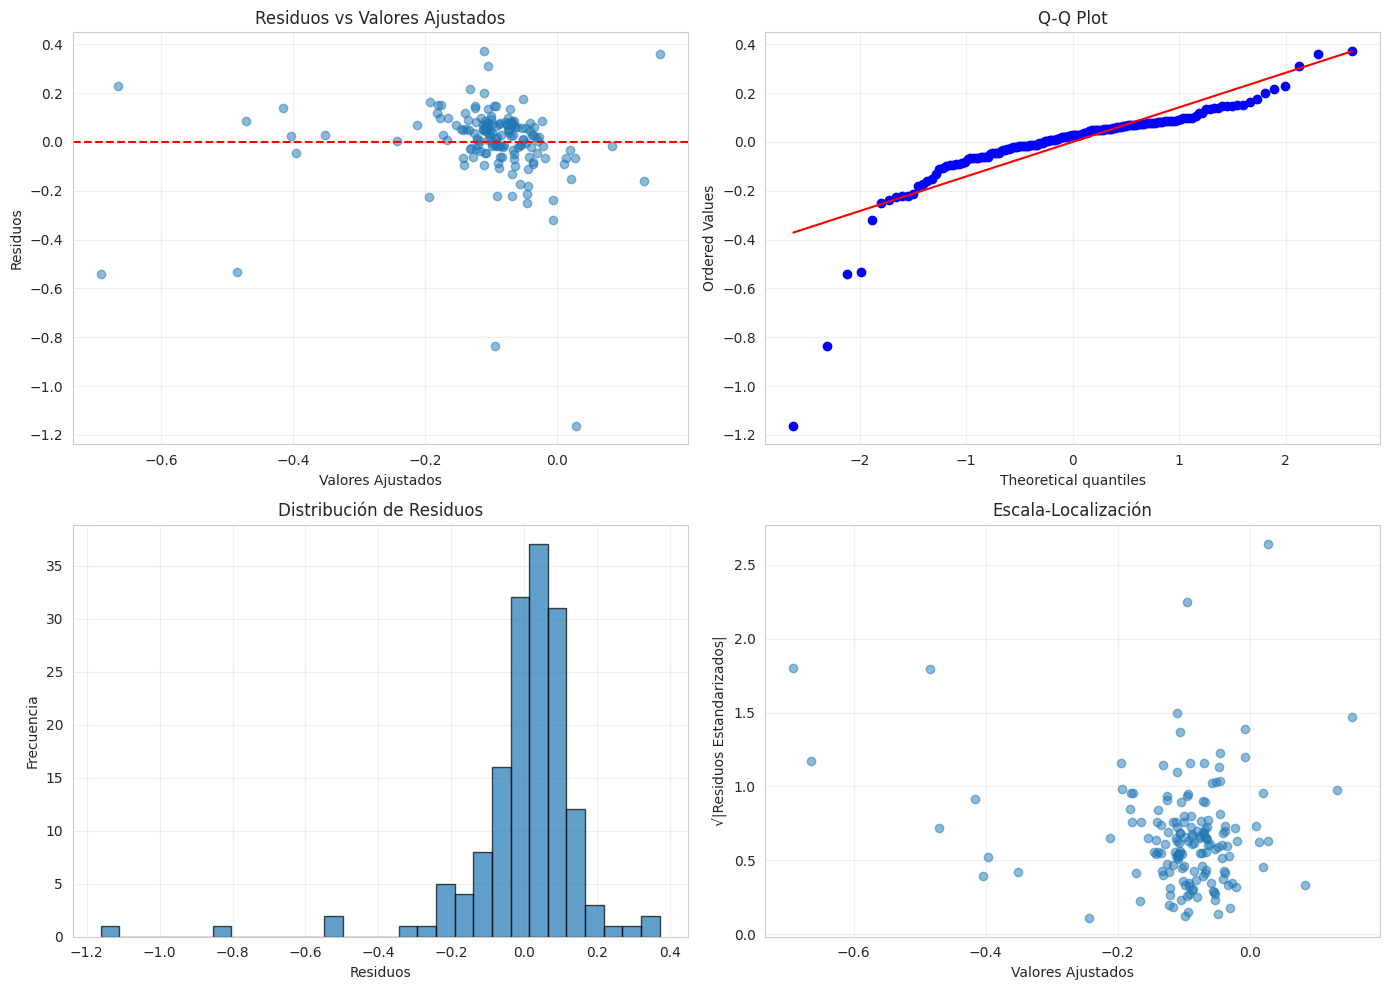

Gráficos de diagnóstico guardados.


In [37]:
# Crear visualizaciones de diagnóstico
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuos vs Valores ajustados
axes[0, 0].scatter(Y_predicho, residuos.reshape(-1), alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Valores Ajustados')
axes[0, 0].set_ylabel('Residuos')
axes[0, 0].set_title('Residuos vs Valores Ajustados')
axes[0, 0].grid(True, alpha=0.3)

# 2. Q-Q plot
stats.probplot(residuos.reshape(-1), dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Histograma de residuos
axes[1, 0].hist(residuos.reshape(-1), bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuos')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Distribución de Residuos')
axes[1, 0].grid(True, alpha=0.3)

# 4. Escala-Localización
std_residuos = np.sqrt(np.abs(residuos.reshape(-1) / residuos.std()))
axes[1, 1].scatter(Y_predicho, std_residuos, alpha=0.5)
axes[1, 1].set_xlabel('Valores Ajustados')
axes[1, 1].set_ylabel('√|Residuos Estandarizados|')
axes[1, 1].set_title('Escala-Localización')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/docs/source/kothari_diagnostic_plots.png', dpi=100, bbox_inches='tight')
plt.show()

print("Gráficos de diagnóstico guardados.")

## Análisis del Índice de Kothari por Empresa y Año

In [38]:
# Análisis del Índice de Kothari por empresa
kothari_por_empresa = df_regresion_limpio.groupby('EMPRESA')['KOTHARI_INDEX'].agg([
    ('Count', 'count'),
    ('Media', 'mean'),
    ('Std', 'std'),
    ('Min', 'min'),
    ('Max', 'max')
]).round(6)

print("\nÍndice de Kothari por Empresa:")
display(kothari_por_empresa)


Índice de Kothari por Empresa:


,Count,Media,Std,Min,Max
EMPRESA,,,,,
ALGORTA NORTE S.A.,11,0.002799,0.070128,-0.158198,0.085796
ANGLO AMERICAN SUR S.A. (EX MINERA SUR ANDES LTDA.),7,0.014815,0.040839,-0.022200,0.071065
CODELCO,9,0.052518,0.037045,-0.003735,0.097866
COMPAÑIA MINERA CERRO COLORADO LTDA.,10,-0.111114,0.248137,-0.539941,0.120337
COMPAÑIA MINERA DOÑA INÉS DE COLLAHUASI SCM,9,-0.042510,0.043092,-0.089993,0.020251
COMPAÑIA MINERA MANTOS DE ORO,10,0.115045,0.169685,-0.179671,0.372025
COMPAÑIA MINERA MARICUNGA S.A.,9,-0.246805,0.444368,-1.161487,0.133885
COMPAÑIA MINERA NEVADA SPA,10,0.134021,0.110717,-0.045686,0.358651
COMPAÑIA MINERA TECK CARMEN DE ANDACOLLO,10,-0.024231,0.031617,-0.066315,0.035513


In [39]:
# Análisis del Índice de Kothari por año
kothari_por_anio = df_regresion_limpio.groupby('ANIO')['KOTHARI_INDEX'].agg([
    ('Count', 'count'),
    ('Media', 'mean'),
    ('Std', 'std'),
    ('Min', 'min'),
    ('Max', 'max')
]).round(6)

print("\nÍndice de Kothari por Año:")
display(kothari_por_anio)


Índice de Kothari por Año:


,Count,Media,Std,Min,Max
ANIO,,,,,
2013,9,0.033485,0.044591,-0.026890,0.097866
2014,15,0.018559,0.088201,-0.152312,0.217703
2015,15,0.034199,0.056311,-0.061730,0.140149
2016,15,0.044990,0.060233,-0.063814,0.151491
2017,16,-0.008310,0.090661,-0.173711,0.177153
2018,16,0.015704,0.109381,-0.238960,0.152483
2019,16,-0.001778,0.242667,-0.837848,0.228955
2020,15,-0.073771,0.373429,-1.161487,0.358651
2021,14,0.002154,0.156157,-0.319723,0.372025


## Visualización del Índice de Kothari

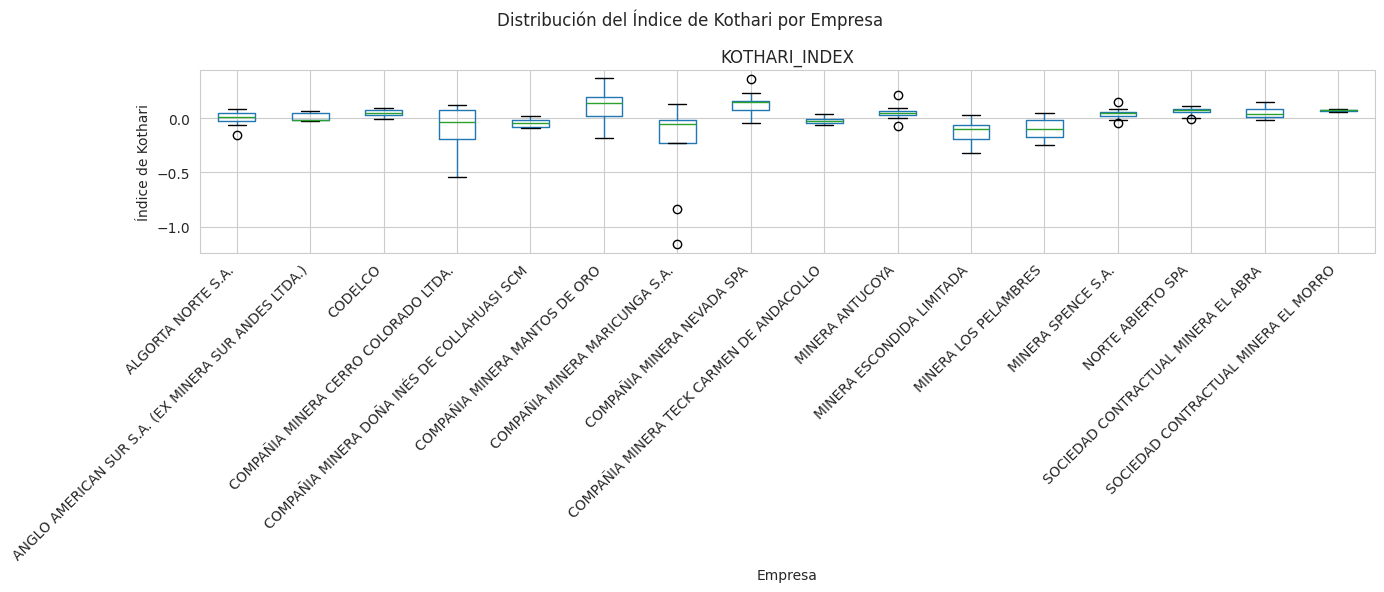

In [40]:
# Visualizar el Índice de Kothari por empresa
fig, ax = plt.subplots(figsize=(14, 6))
df_regresion_limpio.boxplot(column='KOTHARI_INDEX', by='EMPRESA', ax=ax)
plt.suptitle('Distribución del Índice de Kothari por Empresa')
plt.xlabel('Empresa')
plt.ylabel('Índice de Kothari')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/docs/source/kothari_by_company.png', dpi=100, bbox_inches='tight')
plt.show()

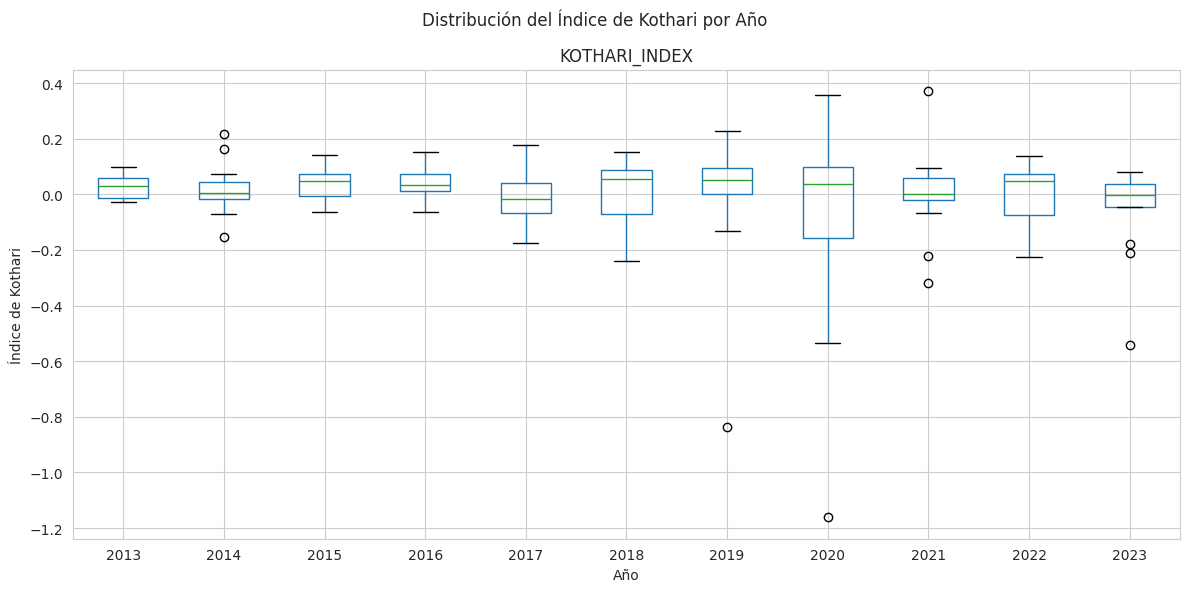

In [41]:
# Visualizar el Índice de Kothari por año
fig, ax = plt.subplots(figsize=(12, 6))
df_regresion_limpio.boxplot(column='KOTHARI_INDEX', by='ANIO', ax=ax)
plt.suptitle('Distribución del Índice de Kothari por Año')
plt.xlabel('Año')
plt.ylabel('Índice de Kothari')
plt.tight_layout()
plt.savefig('/home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/docs/source/kothari_by_year.png', dpi=100, bbox_inches='tight')
plt.show()

## Guardar los resultados

In [42]:
# Preparar el DataFrame con los resultados
df_kothari_results = df_regresion_limpio[[
    'EMPRESA', 'ANIO', 'Y', 'X1', 'X2', 'X3', 'X4', 
    'Y_predicho', 'KOTHARI_INDEX'
]].copy()

# Guardar el DataFrame en el catálogo de Kedro
catalog.save("kothari_results", df_kothari_results)
print("Resultados de la regresión de Kothari guardados en 'kothari_results'.")
print(f"Total de registros: {df_kothari_results.shape[0]}")

[11/02/25 22:10:34] INFO     Saving data to kothari_results (ParquetDataset)...                 ]8;id=303293;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=598120;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#445\445]8;;\

Resultados de la regresión de Kothari guardados en 'kothari_results'.
Total de registros: 158


In [43]:
# Preparar un dataset completo para análisis posterior
# Incluye variables limpias, pesos y el índice de Kothari
df_analysis = df_regresion_limpio[[
    'EMPRESA', 'ANIO', 
    'Y', 'X1', 'X2', 'X3', 'X4',
    'Y_predicho', 'KOTHARI_INDEX',
    'peso_empresa', 'peso_muj_dir', 'peso_muj_ejec'
]].copy()

# Verificar que todas las columnas estén presentes
print("Columnas en el dataset de análisis:")
print(df_analysis.columns.tolist())
print(f"\nDimensiones: {df_analysis.shape[0]} filas × {df_analysis.shape[1]} columnas")

# Mostrar estadísticas básicas
print("\nEstadísticas del dataset de análisis:")
display(df_analysis.describe())

# Guardar el dataset en el catálogo de Kedro
catalog.save("kothari_analysis_data", df_analysis)
print("\nDataset de análisis guardado en 'kothari_analysis_data'.")
print(f"Total de registros: {df_analysis.shape[0]}")

Columnas en el dataset de análisis:
['EMPRESA', 'ANIO', 'Y', 'X1', 'X2', 'X3', 'X4', 'Y_predicho', 'KOTHARI_INDEX', 'peso_empresa', 'peso_muj_dir', 'peso_muj_ejec']

Dimensiones: 158 filas × 12 columnas

Estadísticas del dataset de análisis:


,ANIO,Y,X1,X2,X3,X4,Y_predicho,KOTHARI_INDEX,peso_empresa,peso_muj_dir,peso_muj_ejec
count,158.000000,158.000000,1.580000e+02,158.000000,158.000000,158.000000,158.000000,1.580000e+02,158.000000,116.000000,147.000000
mean,2018.082278,-0.104152,1.528692e-09,-0.001132,0.607883,0.090551,-0.104152,1.405346e-18,5.957640,17.555524,7.895157
std,3.013695,0.198152,1.680881e-09,0.127804,0.314648,21.697441,0.107078,1.667292e-01,10.476870,11.254423,6.698212
min,2013.000000,-1.231483,2.449539e-11,-0.565504,0.000000,-114.930104,-0.691542,-1.161487e+00,0.322828,2.439024,0.000000
25%,2016.000000,-0.139712,1.909897e-10,-0.039772,0.426905,-2.115208,-0.119614,-3.566889e-02,0.537801,8.235294,1.666667
50%,2018.000000,-0.066564,6.247698e-10,0.000513,0.709065,1.781323,-0.092401,2.875846e-02,1.289253,15.789474,8.411215
75%,2021.000000,-0.016076,2.558184e-09,0.052462,0.826674,9.151481,-0.057199,7.348457e-02,6.299398,29.629630,10.526316
max,2023.000000,0.513682,7.754703e-09,0.602822,2.082344,47.668436,0.155031,3.720255e-01,43.635394,35.227273,20.610687


                    INFO     Saving data to kothari_analysis_data (ParquetDataset)...           ]8;id=458244;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=735378;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#445\445]8;;\


Dataset de análisis guardado en 'kothari_analysis_data'.
Total de registros: 158


## Exportar resumen a markdown

In [44]:
# Exportar los resultados a un archivo markdown
output_path = "/home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/docs/source/note_03_Kothari_Regression.md"

with open(output_path, "w", encoding="utf-8") as f:
    f.write("# Regresión de Kothari e Índice de Devengos Discrecionales\n\n")
    f.write("<!-- Este archivo documenta los resultados de la regresión de Kothari y el cálculo del índice de devengos discrecionales. -->\n\n")
    f.write("**Fuente:** notebooks/03_Calculate_Kothari_Index.ipynb\n\n")
    
    f.write("## Modelo de Regresión\n\n")
    f.write("Se implementó la regresión de Kothari conforme a la siguiente ecuación:\n\n")
    f.write("$$\\frac{TA_{i,t}}{A_{i,t-1}} = \\alpha_0 + \\alpha_1(\\frac{1}{A_{i,t-1}}) + \\alpha_2(\\frac{(\\Delta REV_{i,t} - \\Delta REC_{i,t})}{A_{i,t-1}}) + \\alpha_3(\\frac{PPE_{i,t}}{A_{i,t-1}}) + \\alpha_4 ROA_{i,t} + \\varepsilon_{i,t}$$\n\n")
    
    f.write("## Parámetros Estimados\n\n")
    f.write(f"| Parámetro | Estimación |\n")
    f.write(f"|-----------|------------|\n")
    f.write(f"| Intercepto (α₀) | {intercepto:.6f} |\n")
    f.write(f"| X1 (α₁) | {coeficientes[0]:.6f} |\n")
    f.write(f"| X2 (α₂) | {coeficientes[1]:.6f} |\n")
    f.write(f"| X3 (α₃) | {coeficientes[2]:.6f} |\n")
    f.write(f"| X4 (α₄) | {coeficientes[3]:.6f} |\n")
    f.write(f"| R² | {r2:.6f} |\n")
    f.write(f"| Observaciones | {len(Y)} |\n\n")
    
    f.write("## Índice de Kothari (Devengos Discrecionales)\n\n")
    f.write("El Índice de Kothari corresponde a los residuos de la regresión ($\\varepsilon_{i,t}$), que representan la parte de los devengos totales no explicada por el modelo.\n\n")
    f.write(f"| Estadístico | Valor |\n")
    f.write(f"|-------------|-------|\n")
    f.write(f"| Media | {df_regresion_limpio['KOTHARI_INDEX'].mean():.6f} |\n")
    f.write(f"| Mediana | {df_regresion_limpio['KOTHARI_INDEX'].median():.6f} |\n")
    f.write(f"| Desviación Estándar | {df_regresion_limpio['KOTHARI_INDEX'].std():.6f} |\n")
    f.write(f"| Mínimo | {df_regresion_limpio['KOTHARI_INDEX'].min():.6f} |\n")
    f.write(f"| Máximo | {df_regresion_limpio['KOTHARI_INDEX'].max():.6f} |\n")
    f.write(f"| Skewness | {stats.skew(df_regresion_limpio['KOTHARI_INDEX']):.6f} |\n")
    f.write(f"| Kurtosis | {stats.kurtosis(df_regresion_limpio['KOTHARI_INDEX']):.6f} |\n\n")
    
    f.write("## Interpretación\n\n")
    f.write("- **Valores positivos del Índice de Kothari**: Indican que los devengos reales superan lo que el modelo predice como normal, sugiriendo posible manipulación de ganancias hacia el alza.\n")
    f.write("- **Valores negativos del Índice de Kothari**: Indican que los devengos reales son menores que lo predicho por el modelo, sugiriendo posible manipulación hacia la baja.\n")
    f.write("- **Valores cercanos a cero**: Indican que los devengos se comportan como lo esperado por el modelo normal.\n\n")
    f.write("*Generado automáticamente desde el notebook.*\n")

print(f"Resumen guardado en: {output_path}")

Resumen guardado en: /home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/docs/source/note_03_Kothari_Regression.md
